In [1]:
!pip install dm-sonnet tqdm

In [2]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde


import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
seed = 42
np.random.seed(42)
tf.random.set_seed(seed)

In [0]:
tfb = tfp.bijectors
tfd = tfp.distributions

In [0]:
DATASET_SIZE = 10000
BATCH_SIZE = 200
SAMPLE_SIZE = DATASET_SIZE

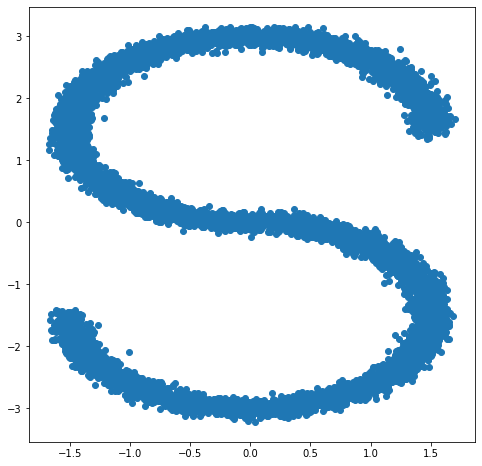

In [6]:
# make S-curve
scurve, _ = skd.make_s_curve(n_samples=DATASET_SIZE, noise=.05, random_state=seed)
scurve = np.vstack([scurve[:, 0], scurve[:, 2]]).T
scurve *= 1.5

scurve_ds = tf.data.Dataset.from_tensor_slices(scurve.astype(np.float32))
scurve_ds = scurve_ds.prefetch(tf.data.experimental.AUTOTUNE)
scurve_ds = scurve_ds.cache()
scurve_ds = scurve_ds.shuffle(DATASET_SIZE)
scurve_ds = scurve_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.scatter(scurve[:, 0], scurve[:, 1])
plt.show()

In [0]:
# Defining the Base Distribution

base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([1.0, 1.0]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)



In [0]:
# Creating the ODEfunc
# state_time_derivative_fn: `Callable(time, state)` -> state_time_derivative
# e.g. Neural network with inputs and outputs of the same shapes and dtypes.

class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output))
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    return self._model(inputs)

In [0]:
LR = 0.001 
NUM_EPOCHS = 50  
STACKED_FFJORDS = 1
NUM_HIDDEN = 64  
NUM_LAYERS = 4  
NUM_OUTPUT = 2

In [0]:
# Creating the ODE Solver
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson

bijectors = []
for _ in range(STACKED_FFJORDS):
  mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
  next_ffjord = tfb.FFJORD(
      state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
      trace_augmentation_fn=trace_augmentation_fn)
  bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

In [0]:
# TransformedDistribution which is the result of warping base_distribution with stacked_ffjord bijector
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)

In [0]:
# Defining energy regularization

def get_batch_jacobian_frobnorm(target_sample):
  with tf.GradientTape(persistent=True, watch_accessed_variables=False) as g:
    g.watch(target_sample)
    y = stacked_ffjord.forward(target_sample)
  bj = g.batch_jacobian(y, target_sample, experimental_use_pfor=False)
  del y
  gc.collect()
  bj = tf.reshape(bj,(bj.shape[0], -1))
  return tf.math.reduce_mean(tf.norm(bj, ord=2, axis=1) / bj.shape[1] ** 0.5)

def get_squared_l2_regularization_fn(target_sample):
    dx = stacked_ffjord.forward(target_sample)
    to_return = tf.reshape(dx, (dx.shape[0], -1))
    return tf.math.reduce_mean(tf.math.pow(tf.norm(to_return, ord=2, axis=1), 2))

def get_energy_reg(target_sample, l_e=0.001, l_j=0.001):
  return (l_e * get_squared_l2_regularization_fn(target_sample)) + (l_j * get_batch_jacobian_frobnorm(target_sample))

In [0]:
# Defining the training_function

@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample)) + get_energy_reg(target_sample)
    # loss += get_energy_reg(target_sample) #add energy reg 
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply(gradients, variables)
  return loss


@tf.function
def get_samples():
  base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
  transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
  return base_distribution_samples, transformed_samples


@tf.function
def get_transformed_grid():
  transformed_grid = stacked_ffjord.forward(grid)
  return transformed_grid

In [0]:
### FUNCS NEEDED FOR PLOTTING ### 


def make_grid(xmin, xmax, ymin, ymax, gridlines, pts):
  xpts = np.linspace(xmin, xmax, pts)
  ypts = np.linspace(ymin, ymax, pts)
  xgrid = np.linspace(xmin, xmax, gridlines)
  ygrid = np.linspace(ymin, ymax, gridlines)
  xlines = np.stack([a.ravel() for a in np.meshgrid(xpts, ygrid)])
  ylines = np.stack([a.ravel() for a in np.meshgrid(xgrid, ypts)])
  return np.concatenate([xlines, ylines], 1).T

grid = make_grid(-3, 3, -3, 3, 4, 100)


def plot_density(data, axis):
  x, y = np.squeeze(np.split(data, 2, axis=1))
  levels = np.linspace(0.0, 0.75, 10)
  kwargs = {'levels': levels}
  return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis, **kwargs)


def plot_points(data, axis, s=10, color='b', label=''):
  x, y = np.squeeze(np.split(data, 2, axis=1))
  axis.scatter(x, y, c=color, s=s, label=label)


def plot_panel(
    grid, samples, transformed_grid, transformed_samples,
    dataset, axarray, limits=True):
  if len(axarray) != 4:
    raise ValueError('Expected 4 axes for the panel')
  ax1, ax2, ax3, ax4 = axarray
  plot_points(data=grid, axis=ax1, s=20, color='black', label='grid')
  plot_points(samples, ax1, s=30, color='blue', label='samples')
  plot_points(transformed_grid, ax2, s=20, color='black', label='ode(grid)')
  plot_points(transformed_samples, ax2, s=30, color='blue', label='ode(samples)')
  ax3 = plot_density(transformed_samples, ax3)
  ax4 = plot_density(dataset, ax4)
  if limits:
    set_limits([ax1], -3.0, 3.0, -3.0, 3.0)
    set_limits([ax2], -2.0, 3.0, -2.0, 3.0)
    set_limits([ax3, ax4], -1.5, 2.5, -0.75, 1.25)


def set_limits(axes, min_x, max_x, min_y, max_y):
  if isinstance(axes, list):
    for axis in axes:
      set_limits(axis, min_x, max_x, min_y, max_y)
  else:
    axes.set_xlim(min_x, max_x)
    axes.set_ylim(min_y, max_y)

In [15]:
evaluation_samples = []
base_samples, transformed_samples = get_samples()
transformed_grid = get_transformed_grid()
evaluation_samples.append((base_samples, transformed_samples, transformed_grid))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# panel_id = 0
# panel_data = evaluation_samples[panel_id]
# fig, axarray = plt.subplots(
#   1, 4, figsize=(16, 6))
# plot_panel(
#     grid, panel_data[0], panel_data[2], panel_data[1], scurve, axarray, False)
# plt.tight_layout()

In [17]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(40):
  base_samples, transformed_samples = get_samples()
  transformed_grid = get_transformed_grid()
  evaluation_samples.append(
      (base_samples, transformed_samples, transformed_grid))
  for batch in scurve_ds:
    _ = train_step(optimizer, batch)

  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|██████████| 40/40 [22:32<00:00, 33.80s/it]


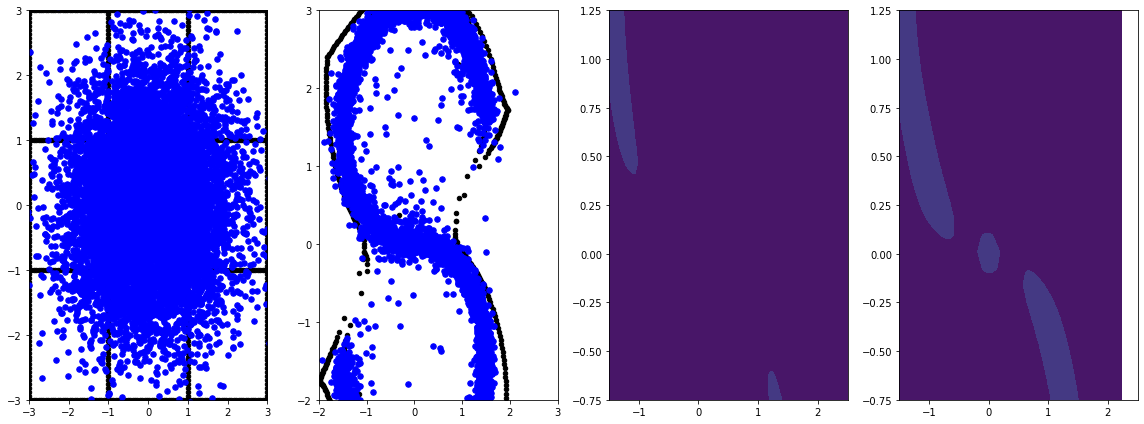

In [18]:
panel_id = -1
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(
  1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], scurve, axarray)
plt.tight_layout()

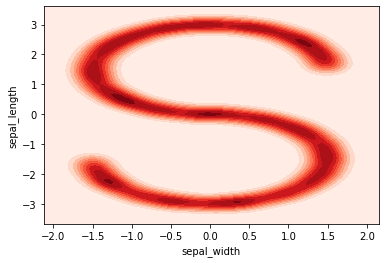

In [19]:
import seaborn as sns
import pandas as pd


df = pd.DataFrame(scurve, columns=['sepal_width','sepal_length'])
sns.kdeplot(df.sepal_width, df.sepal_length, cmap="Reds", shade=True, bw=.15)

plt.show()

# Original

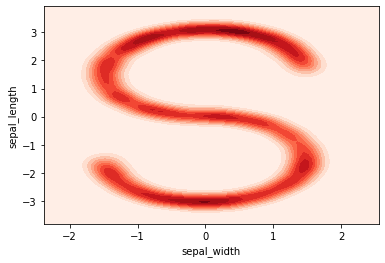

In [20]:
df = pd.DataFrame(panel_data[1], columns=['sepal_width','sepal_length'])
sns.kdeplot(df.sepal_width, df.sepal_length, cmap="Reds", shade=True, bw=.15)
plt.show()

# Predicted